# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

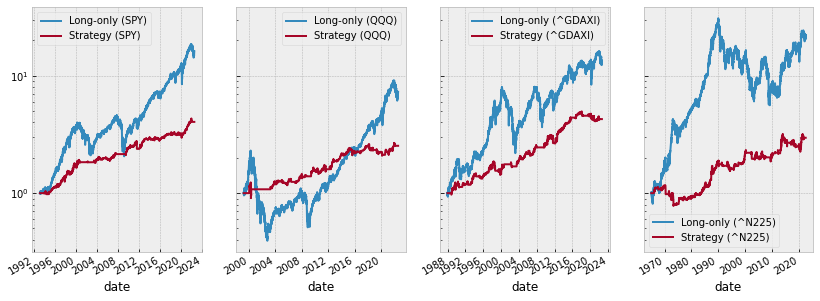

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.094405,0.047415,0.085080,0.039759,0.075092,0.041895,0.055062,0.019330
Annualised vol,0.188499,0.072991,0.277594,0.100183,0.222663,0.082126,0.201611,0.074933
Sharpe ratio,0.500824,0.649612,0.306492,0.396860,0.337244,0.510137,0.273112,0.257960
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.171056,0.336863,0.102551,0.149479,0.103311,0.179069,0.067255,0.057684
Skewness,-0.066905,-0.833150,0.211694,1.613476,-0.117848,-1.859174,-0.187004,-3.343586
Kurtosis,11.599470,40.231064,6.862475,72.706681,6.460116,69.244680,8.814978,121.867010
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


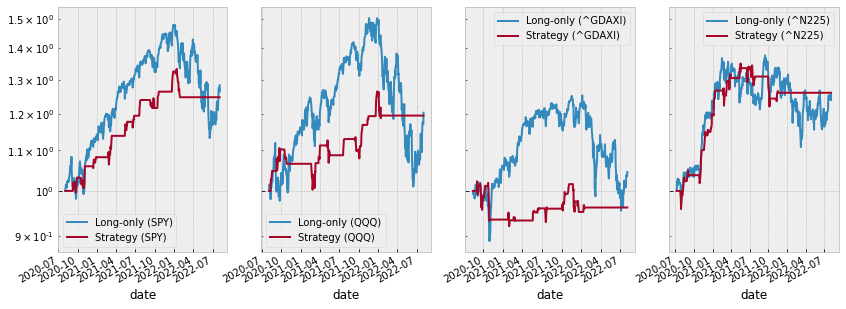

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

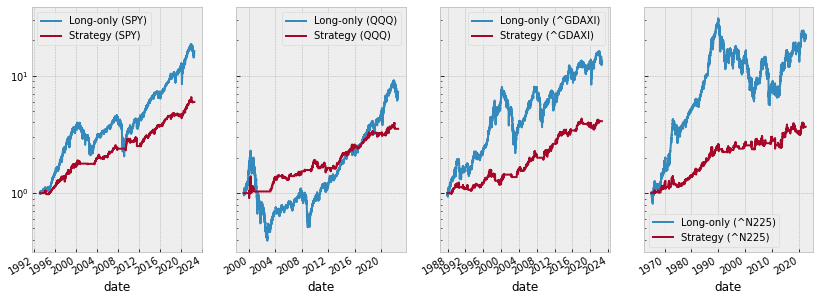

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.094405,0.060662,0.085080,0.054005,0.075092,0.040709,0.055062,0.023181
Annualised vol,0.188499,0.082448,0.277594,0.114389,0.222663,0.088605,0.201611,0.086831
Sharpe ratio,0.500824,0.735756,0.306492,0.472118,0.337244,0.459444,0.273112,0.266970
Max drawdown,0.551894,0.163106,0.829639,0.282275,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.171056,0.371916,0.102551,0.191320,0.103311,0.158552,0.067255,0.105844
Skewness,-0.066905,-0.602876,0.211694,0.780251,-0.117848,-0.221391,-0.187004,-2.474997
Kurtosis,11.599470,28.247570,6.862475,47.957743,6.460116,16.395590,8.814978,83.182867
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


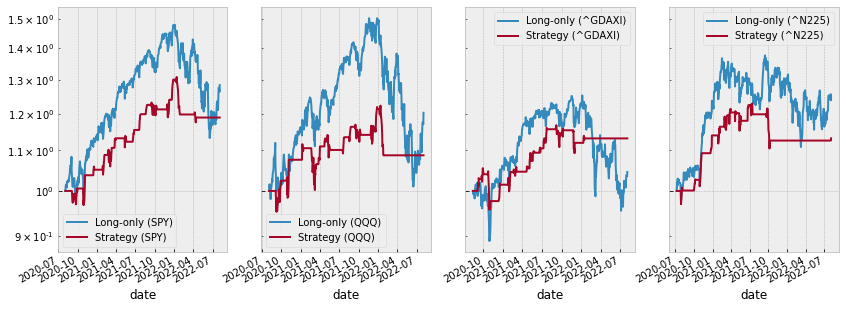

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

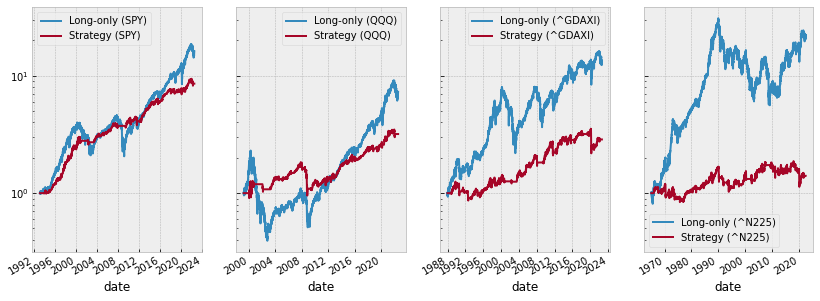

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.094405,0.072878,0.085080,0.049629,0.075092,0.030367,0.055062,0.006043
Annualised vol,0.188499,0.098965,0.277594,0.145022,0.222663,0.118105,0.201611,0.105919
Sharpe ratio,0.500824,0.736397,0.306492,0.342219,0.337244,0.257120,0.273112,0.057049
Max drawdown,0.551894,0.153226,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.171056,0.475624,0.102551,0.103365,0.103311,0.079455,0.067255,0.015262
Skewness,-0.066905,-0.309811,0.211694,0.655324,-0.117848,-1.215002,-0.187004,-1.642614
Kurtosis,11.599470,17.784321,6.862475,32.488501,6.460116,37.243765,8.814978,46.277244
Worst return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


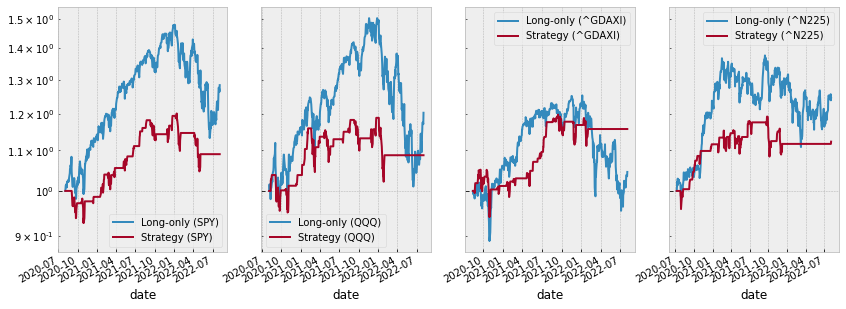

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

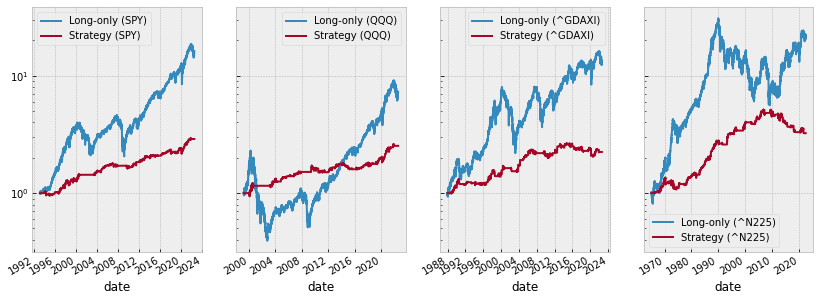

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.094405,0.036038,0.085080,0.039716,0.075092,0.023298,0.055062,0.020933
Annualised vol,0.188499,0.062219,0.277594,0.081827,0.222663,0.066469,0.201611,0.058451
Sharpe ratio,0.500824,0.579220,0.306492,0.485361,0.337244,0.350513,0.273112,0.358137
Max drawdown,0.551894,0.111611,0.829639,0.131615,0.726848,0.238856,0.818712,0.370691
Calmar ratio,0.171056,0.322893,0.102551,0.301756,0.103311,0.097541,0.067255,0.056471
Skewness,-0.066905,-0.788336,0.211694,0.433587,-0.117848,-0.275397,-0.187004,-1.801604
Kurtosis,11.599470,47.063072,6.862475,40.519657,6.460116,27.645664,8.814978,78.099274
Worst return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106267,-0.216097,-0.124379,-0.243342,-0.127345


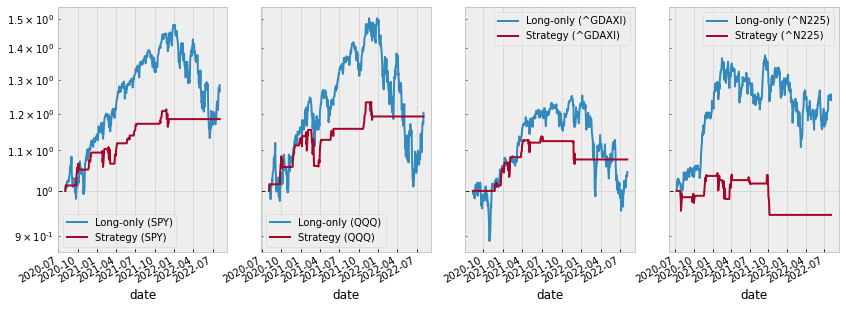

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 04-Aug-2022 07:06
